# Task 3: Correlation Analysis Between News Sentiment and Stock Movements
# Comprehensive Integration of Financial News and Stock Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# NLP and Sentiment Analysis
import nltk
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
import re

# Statistical Analysis
from scipy.stats import pearsonr, spearmanr
from scipy import stats
import statsmodels.api as sm

# Download required NLTK data
nltk.download('vader_lexicon', quiet=True)

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("=== CORRELATION ANALYSIS: NEWS SENTIMENT & STOCK MOVEMENTS ===")
print("All libraries imported successfully!")

=== CORRELATION ANALYSIS: NEWS SENTIMENT & STOCK MOVEMENTS ===
All libraries imported successfully!


2 :Enhanced Sentiment Analysis: Enhanced Sentiment Analysis for Financial Headlines

In [3]:

class FinancialSentimentAnalyzer:
    """
    Comprehensive sentiment analyzer tailored for financial news
    """
    def __init__(self):
        self.sia = SentimentIntensityAnalyzer()
        # Financial lexicon enhancements
        self.positive_financial_terms = {
            'bullish', 'surge', 'rally', 'gain', 'profit', 'growth', 'beat', 'outperform',
            'upgrade', 'buy', 'outperform', 'strong', 'positive', 'optimistic', 'recovery'
        }
        self.negative_financial_terms = {
            'bearish', 'plunge', 'drop', 'loss', 'decline', 'miss', 'underperform',
            'downgrade', 'sell', 'weak', 'negative', 'pessimistic', 'crash', 'slump'
        }
    
    def analyze_sentiment(self, text):
        """
        Perform comprehensive sentiment analysis using multiple methods
        """
        if pd.isna(text) or text == '':
            return 0.0
        
        text = str(text).lower()
        
        # Method 1: TextBlob sentiment
        try:
            blob = TextBlob(text)
            textblob_score = blob.sentiment.polarity
        except:
            textblob_score = 0.0
        
        # Method 2: VADER sentiment (specifically trained for social media/text)
        vader_scores = self.sia.polarity_scores(text)
        vader_score = vader_scores['compound']
        
        # Method 3: Financial term boosting
        financial_boost = 0.0
        positive_count = sum(1 for term in self.positive_financial_terms if term in text)
        negative_count = sum(1 for term in self.negative_financial_terms if term in text)
        
        if positive_count > negative_count:
            financial_boost = 0.1
        elif negative_count > positive_count:
            financial_boost = -0.1
        
        # Combined score (weighted average)
        combined_score = (textblob_score * 0.4 + vader_score * 0.5 + financial_boost * 0.1)
        
        # Normalize to [-1, 1]
        return max(-1.0, min(1.0, combined_score))
    
    def get_sentiment_label(self, score):
        """Convert sentiment score to categorical label"""
        if score > 0.1:
            return 'positive'
        elif score < -0.1:
            return 'negative'
        else:
            return 'neutral'

# Initialize sentiment analyzer
sentiment_analyzer = FinancialSentimentAnalyzer()

print("Financial Sentiment Analyzer initialized successfully!")

Financial Sentiment Analyzer initialized successfully!


3: Load and Prepare Datasets

In [5]:
# Load and Prepare Datasets for Correlation Analysis

def load_and_prepare_datasets():
    """
    Load both news and stock datasets and prepare for correlation analysis
    """
    # Load news data (from Task 1)
    try:
        news_df = pd.read_csv('../data/raw_analyst_ratings.csv')
        unnamed_cols = news_df.columns[news_df.columns.str.contains('Unnamed', case=False)]
        news_df = news_df.drop(columns=unnamed_cols, axis=1)
        print(f"✓ News data loaded: {len(news_df):,} articles")
    except FileNotFoundError:
        print("✗ News data file not found. Please ensure 'data/financial_news.csv' exists.")
        return None, None
    
    # Load stock data (from Task 2)
    stock_symbols = ['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'NVDA']
    stock_data = {}
    
    for symbol in stock_symbols:
        try:
            stock_df = pd.read_csv(f'../data/yfinancedata/{symbol}.csv', index_col=0, parse_dates=True)
            stock_data[symbol] = stock_df
            print(f"✓ {symbol} data loaded: {len(stock_df)} trading days")
        except FileNotFoundError:
            print(f"✗ {symbol} data file not found")
            continue
    
    return news_df, stock_data

print("\n" + "="*60)
print("LOADING AND PREPARING DATASETS")
print("="*60)

news_df, stock_data = load_and_prepare_datasets()

if news_df is not None and stock_data:
    print(f"\n📊 Dataset Summary:")
    print(f"   • News Articles: {len(news_df):,}")
    print(f"   • Stocks Loaded: {len(stock_data)}")
    print(f"   • News Date Range: {news_df['date'].min()} to {news_df['date'].max()}")
    
    # Display sample of news data
    print(f"\nSample News Headlines:")
    for i, headline in enumerate(news_df['headline'].head(5)):
        print(f"   {i+1}. {headline}")
else:
    print("❌ Failed to load datasets. Please check file paths and availability.")


LOADING AND PREPARING DATASETS
✓ News data loaded: 1,407,328 articles
✓ AAPL data loaded: 3774 trading days
✓ AMZN data loaded: 3774 trading days
✓ GOOG data loaded: 3774 trading days
✓ META data loaded: 2923 trading days
✓ MSFT data loaded: 3774 trading days
✓ NVDA data loaded: 3774 trading days

📊 Dataset Summary:
   • News Articles: 1,407,328
   • Stocks Loaded: 6
   • News Date Range: 2009-02-14 00:00:00 to 2020-06-11 17:12:35-04:00

Sample News Headlines:
   1. Stocks That Hit 52-Week Highs On Friday
   2. Stocks That Hit 52-Week Highs On Wednesday
   3. 71 Biggest Movers From Friday
   4. 46 Stocks Moving In Friday's Mid-Day Session
   5. B of A Securities Maintains Neutral on Agilent Technologies, Raises Price Target to $88


4: Date Alignment and Data Integration

In [12]:
# Date Alignment and Data Integration

def align_and_integrate_data(news_df, stock_data):
    """
    Align news and stock data by dates and integrate for analysis
    """
    # Convert news date to datetime and normalize
    print("Processing news data dates...")
    news_df['date'] = pd.to_datetime(
        news_df['date'],
        format='mixed',   # allow mixed formats
        utc=True,         # output in UTC
        errors='coerce'   # convert problematic dates to NaT instead of raising error
    )
    
    # Remove any rows with invalid dates
    news_df = news_df.dropna(subset=['date'])
    news_df['date_normalized'] = news_df['date'].dt.date
    print(f"✓ News data processed: {len(news_df):,} articles with valid dates")
    
    # Perform sentiment analysis on all headlines
    print("Performing sentiment analysis on news headlines...")
    news_df['sentiment_score'] = news_df['headline'].apply(
        lambda x: sentiment_analyzer.analyze_sentiment(x)
    )
    news_df['sentiment_label'] = news_df['sentiment_score'].apply(
        lambda x: sentiment_analyzer.get_sentiment_label(x)
    )
    print("✓ Sentiment analysis completed")
    
    # Create integrated dataset for each stock
    integrated_data = {}
    
    for symbol, stock_df in stock_data.items():
        print(f"\nIntegrating data for {symbol}...")
        
        # Ensure stock data has date index and create normalized date column
        stock_df = stock_df.copy()
        stock_df.index = pd.to_datetime(stock_df.index)
        stock_df['date_normalized'] = stock_df.index.date
        
        # Calculate daily returns
        stock_df['daily_return'] = stock_df['Close'].pct_change() * 100
        stock_df['daily_return_abs'] = stock_df['daily_return'].abs()
        
        # Filter news for this specific stock
        # First try exact symbol match
        stock_news = news_df[news_df['stock'] == symbol].copy()
        
        if len(stock_news) == 0:
            print(f"   ⚠ No direct news found for {symbol}, using all financial news...")
            # If no direct stock match, use all financial news
            stock_news = news_df.copy()
        else:
            print(f"   ✓ Found {len(stock_news):,} articles specifically for {symbol}")
        
        # Aggregate daily sentiment
        if len(stock_news) > 0:
            # Ensure date_normalized is consistent type for grouping
            stock_news['date_normalized'] = pd.to_datetime(stock_news['date_normalized'])
            
            daily_sentiment = stock_news.groupby('date_normalized').agg({
                'sentiment_score': ['mean', 'count', 'std'],
                'headline': 'count'
            }).round(4)
            
            # Flatten column names
            daily_sentiment.columns = ['sentiment_mean', 'sentiment_count', 'sentiment_std', 'article_count']
            daily_sentiment = daily_sentiment.reset_index()
            
            # Reset stock_df index for merging and ensure consistent date type
            stock_df_reset = stock_df.reset_index()
            stock_df_reset['date_normalized'] = pd.to_datetime(stock_df_reset['date_normalized'])
            
            print(f"   • Stock data dates: {stock_df_reset['date_normalized'].dtype}")
            print(f"   • Sentiment data dates: {daily_sentiment['date_normalized'].dtype}")
            
            # Merge with stock data using pd.merge
            merged_data = pd.merge(
                stock_df_reset,
                daily_sentiment,
                on='date_normalized',
                how='inner'  # Only keep dates that exist in both datasets
            )
            
            if len(merged_data) == 0:
                print(f"   ⚠ No overlapping dates found between news and stock data for {symbol}")
                print(f"   • Stock date range: {stock_df_reset['date_normalized'].min()} to {stock_df_reset['date_normalized'].max()}")
                print(f"   • News date range: {daily_sentiment['date_normalized'].min()} to {daily_sentiment['date_normalized'].max()}")
                continue
            
            # Calculate lagged correlations (news today vs returns tomorrow)
            merged_data['returns_tomorrow'] = merged_data['daily_return'].shift(-1)
            merged_data['returns_next_week'] = merged_data['daily_return'].shift(-5)
            
            # Set date as index for consistency
            merged_data.set_index('date_normalized', inplace=True)
            
            integrated_data[symbol] = merged_data
            print(f"   ✓ Integrated {len(merged_data)} days of data")
            print(f"   ✓ News coverage: {merged_data['article_count'].sum():,} articles")
            print(f"   ✓ Date range: {merged_data.index.min()} to {merged_data.index.max()}")
        else:
            print(f"   ✗ No news data available for integration with {symbol}")
    
    return integrated_data

print("\n" + "="*60)
print("DATE ALIGNMENT AND DATA INTEGRATION")
print("="*60)

integrated_data = align_and_integrate_data(news_df, stock_data)

if integrated_data:
    print(f"\n✅ SUCCESSFULLY INTEGRATED DATA FOR {len(integrated_data)} STOCKS")
    
    # Display detailed summary for each stock
    for symbol, data in integrated_data.items():
        print(f"\n📊 {symbol} Integration Summary:")
        print(f"   • Integrated Days: {len(data):,}")
        print(f"   • Date Range: {data.index.min()} to {data.index.max()}")
        print(f"   • Total Articles: {data['article_count'].sum():,}")
        print(f"   • Average Articles/Day: {data['article_count'].mean():.1f}")
        print(f"   • Average Sentiment: {data['sentiment_mean'].mean():.3f}")
        print(f"   • Average Daily Return: {data['daily_return'].mean():.3f}%")
        
        # Check data quality
        missing_sentiment = data['sentiment_mean'].isna().sum()
        missing_returns = data['daily_return'].isna().sum()
        if missing_sentiment > 0 or missing_returns > 0:
            print(f"   • Data Quality: {missing_sentiment} missing sentiment, {missing_returns} missing returns")
    
    # Display sample data from first stock
    first_symbol = list(integrated_data.keys())[0]
    sample_data = integrated_data[first_symbol]
    
    print(f"\n" + "="*50)
    print(f"SAMPLE INTEGRATED DATA FOR {first_symbol}")
    print("="*50)
    print(sample_data[['Close', 'daily_return', 'sentiment_mean', 'article_count']].head(10))
    
else:
    print("❌ No data integration successful. Checking data compatibility...")
    
    # Debug information
    if news_df is not None:
        print(f"\n📰 News Data Info:")
        print(f"   • Total articles: {len(news_df):,}")
        print(f"   • Unique stocks in news: {news_df['stock'].nunique()}")
        print(f"   • Sample stocks: {news_df['stock'].value_counts().head(10).index.tolist()}")
        print(f"   • News date range: {news_df['date_normalized'].min()} to {news_df['date_normalized'].max()}")
        print(f"   • News date type: {news_df['date_normalized'].dtype}")
    
    if stock_data:
        print(f"\n📈 Stock Data Info:")
        for symbol, data in stock_data.items():
            data_copy = data.copy()
            data_copy.index = pd.to_datetime(data_copy.index)
            data_copy['date_normalized'] = data_copy.index.date
            print(f"   • {symbol}: {len(data)} days, {data_copy['date_normalized'].min()} to {data_copy['date_normalized'].max()}")
            print(f"   • {symbol} date type: {data_copy['date_normalized'].dtype}")
    
    # Check for overlapping date ranges
    if news_df is not None and stock_data:
        print(f"\n🔍 Checking for date range overlaps...")
        news_min_date = news_df['date_normalized'].min()
        news_max_date = news_df['date_normalized'].max()
        
        for symbol, data in stock_data.items():
            data_copy = data.copy()
            data_copy.index = pd.to_datetime(data_copy.index)
            stock_min_date = data_copy.index.min().date()
            stock_max_date = data_copy.index.max().date()
            
            overlap_start = max(news_min_date, stock_min_date)
            overlap_end = min(news_max_date, stock_max_date)
            
            if overlap_start <= overlap_end:
                print(f"   • {symbol}: OVERLAP FOUND - {overlap_start} to {overlap_end}")
            else:
                print(f"   • {symbol}: NO OVERLAP - News: {news_min_date}-{news_max_date}, Stock: {stock_min_date}-{stock_max_date}")


DATE ALIGNMENT AND DATA INTEGRATION
Processing news data dates...
✓ News data processed: 1,407,328 articles with valid dates
Performing sentiment analysis on news headlines...
✓ Sentiment analysis completed

Integrating data for AAPL...
   ✓ Found 441 articles specifically for AAPL
   • Stock data dates: datetime64[ns]
   • Sentiment data dates: datetime64[ns]
   ✓ Integrated 61 days of data
   ✓ News coverage: 415 articles
   ✓ Date range: 2020-03-09 00:00:00 to 2020-06-10 00:00:00

Integrating data for AMZN...
   ✓ Found 278 articles specifically for AMZN
   • Stock data dates: datetime64[ns]
   • Sentiment data dates: datetime64[ns]
   ✓ Integrated 28 days of data
   ✓ News coverage: 265 articles
   ✓ Date range: 2020-04-27 00:00:00 to 2020-06-10 00:00:00

Integrating data for GOOG...
   ✓ Found 1,199 articles specifically for GOOG
   • Stock data dates: datetime64[ns]
   • Sentiment data dates: datetime64[ns]
   ✓ Integrated 352 days of data
   ✓ News coverage: 1,168 articles
   ✓

5:Comprehensive Correlation Analysis

In [13]:
# Comprehensive Correlation Analysis

def perform_correlation_analysis(integrated_data):
    """
    Perform comprehensive correlation analysis between sentiment and returns
    """
    correlation_results = {}
    
    for symbol, data in integrated_data.items():
        print(f"\nAnalyzing correlations for {symbol}...")
        
        # Clean data (remove NaN values for correlation)
        clean_data = data.dropna(subset=['sentiment_mean', 'daily_return', 'returns_tomorrow'])
        
        if len(clean_data) < 10:  # Minimum data points requirement
            print(f"   ⚠ Insufficient data for {symbol}")
            continue
        
        # Calculate various correlations
        correlations = {}
        
        # Same-day correlation
        corr_same_day, p_value_same = pearsonr(clean_data['sentiment_mean'], clean_data['daily_return'])
        correlations['same_day'] = {
            'correlation': corr_same_day,
            'p_value': p_value_same,
            'significant': p_value_same < 0.05
        }
        
        # Next-day correlation (lagged effect)
        corr_next_day, p_value_next = pearsonr(clean_data['sentiment_mean'], clean_data['returns_tomorrow'])
        correlations['next_day'] = {
            'correlation': corr_next_day,
            'p_value': p_value_next,
            'significant': p_value_next < 0.05
        }
        
        # Next-week correlation
        clean_data_week = data.dropna(subset=['sentiment_mean', 'returns_next_week'])
        if len(clean_data_week) >= 10:
            corr_next_week, p_value_week = pearsonr(clean_data_week['sentiment_mean'], clean_data_week['returns_next_week'])
            correlations['next_week'] = {
                'correlation': corr_next_week,
                'p_value': p_value_week,
                'significant': p_value_week < 0.05
            }
        
        # Volume-weighted sentiment correlation
        if 'Volume' in clean_data.columns:
            weighted_corr, weighted_p = pearsonr(
                clean_data['sentiment_mean'], 
                clean_data['daily_return'],
                # sample_weight=clean_data['Volume']  # Weight by trading volume
            )
            correlations['volume_weighted'] = {
                'correlation': weighted_corr,
                'p_value': weighted_p,
                'significant': weighted_p < 0.05
            }
        
        # Extreme sentiment analysis
        high_sentiment = clean_data[clean_data['sentiment_mean'] > 0.3]
        low_sentiment = clean_data[clean_data['sentiment_mean'] < -0.3]
        
        correlations['extreme_sentiment'] = {
            'high_sentiment_days': len(high_sentiment),
            'low_sentiment_days': len(low_sentiment),
            'high_sentiment_avg_return': high_sentiment['daily_return'].mean() if len(high_sentiment) > 0 else 0,
            'low_sentiment_avg_return': low_sentiment['daily_return'].mean() if len(low_sentiment) > 0 else 0
        }
        
        correlation_results[symbol] = {
            'data_points': len(clean_data),
            'avg_sentiment': clean_data['sentiment_mean'].mean(),
            'avg_return': clean_data['daily_return'].mean(),
            'sentiment_volatility': clean_data['sentiment_mean'].std(),
            'return_volatility': clean_data['daily_return'].std(),
            'correlations': correlations
        }
        
        # Print summary for this stock
        print(f"   • Data points: {len(clean_data)}")
        print(f"   • Same-day correlation: {corr_same_day:.4f} (p={p_value_same:.4f})")
        print(f"   • Next-day correlation: {corr_next_day:.4f} (p={p_value_next:.4f})")
        if 'next_week' in correlations:
            print(f"   • Next-week correlation: {corr_next_week:.4f} (p={p_value_week:.4f})")
    
    return correlation_results

print("\n" + "="*60)
print("COMPREHENSIVE CORRELATION ANALYSIS")
print("="*60)

correlation_results = perform_correlation_analysis(integrated_data)

# Display overall correlation summary
if correlation_results:
    print("\n" + "="*60)
    print("CORRELATION ANALYSIS SUMMARY")
    print("="*60)
    
    summary_data = []
    for symbol, results in correlation_results.items():
        same_day_corr = results['correlations']['same_day']['correlation']
        same_day_sig = results['correlations']['same_day']['significant']
        next_day_corr = results['correlations']['next_day']['correlation']
        next_day_sig = results['correlations']['next_day']['significant']
        
        summary_data.append({
            'Symbol': symbol,
            'Data_Points': results['data_points'],
            'Avg_Sentiment': results['avg_sentiment'],
            'Avg_Return': results['avg_return'],
            'Same_Day_Corr': same_day_corr,
            'Same_Day_Sig': '✓' if same_day_sig else '✗',
            'Next_Day_Corr': next_day_corr,
            'Next_Day_Sig': '✓' if next_day_sig else '✗',
            'Strength': 'Strong' if abs(same_day_corr) > 0.1 else 'Weak'
        })
    
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.round(4))


COMPREHENSIVE CORRELATION ANALYSIS

Analyzing correlations for AAPL...
   • Data points: 60
   • Same-day correlation: 0.1254 (p=0.3399)
   • Next-day correlation: -0.2048 (p=0.1164)
   • Next-week correlation: 0.1008 (p=0.4596)

Analyzing correlations for AMZN...
   • Data points: 27
   • Same-day correlation: 0.0808 (p=0.6885)
   • Next-day correlation: -0.3197 (p=0.1040)
   • Next-week correlation: -0.0965 (p=0.6614)

Analyzing correlations for GOOG...
   • Data points: 351
   • Same-day correlation: 0.1793 (p=0.0007)
   • Next-day correlation: -0.0119 (p=0.8246)
   • Next-week correlation: 0.0654 (p=0.2245)

Analyzing correlations for META...
   • Data points: 2027
   • Same-day correlation: 0.1511 (p=0.0000)
   • Next-day correlation: -0.0055 (p=0.8062)
   • Next-week correlation: -0.0078 (p=0.7267)

Analyzing correlations for MSFT...
   • Data points: 2756
   • Same-day correlation: 0.1057 (p=0.0000)
   • Next-day correlation: -0.0082 (p=0.6658)
   • Next-week correlation: -0.02

6: Advanced Statistical Analysis and Visualization


CREATING COMPREHENSIVE VISUALIZATIONS
Columns available in AAPL data:
['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'daily_return', 'daily_return_abs', 'sentiment_mean', 'sentiment_count', 'sentiment_std', 'article_count', 'returns_tomorrow', 'returns_next_week']

Index name: date_normalized
Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Sample index values: [Timestamp('2020-03-09 00:00:00'), Timestamp('2020-03-10 00:00:00'), Timestamp('2020-03-11 00:00:00'), Timestamp('2020-03-12 00:00:00'), Timestamp('2020-03-13 00:00:00')]


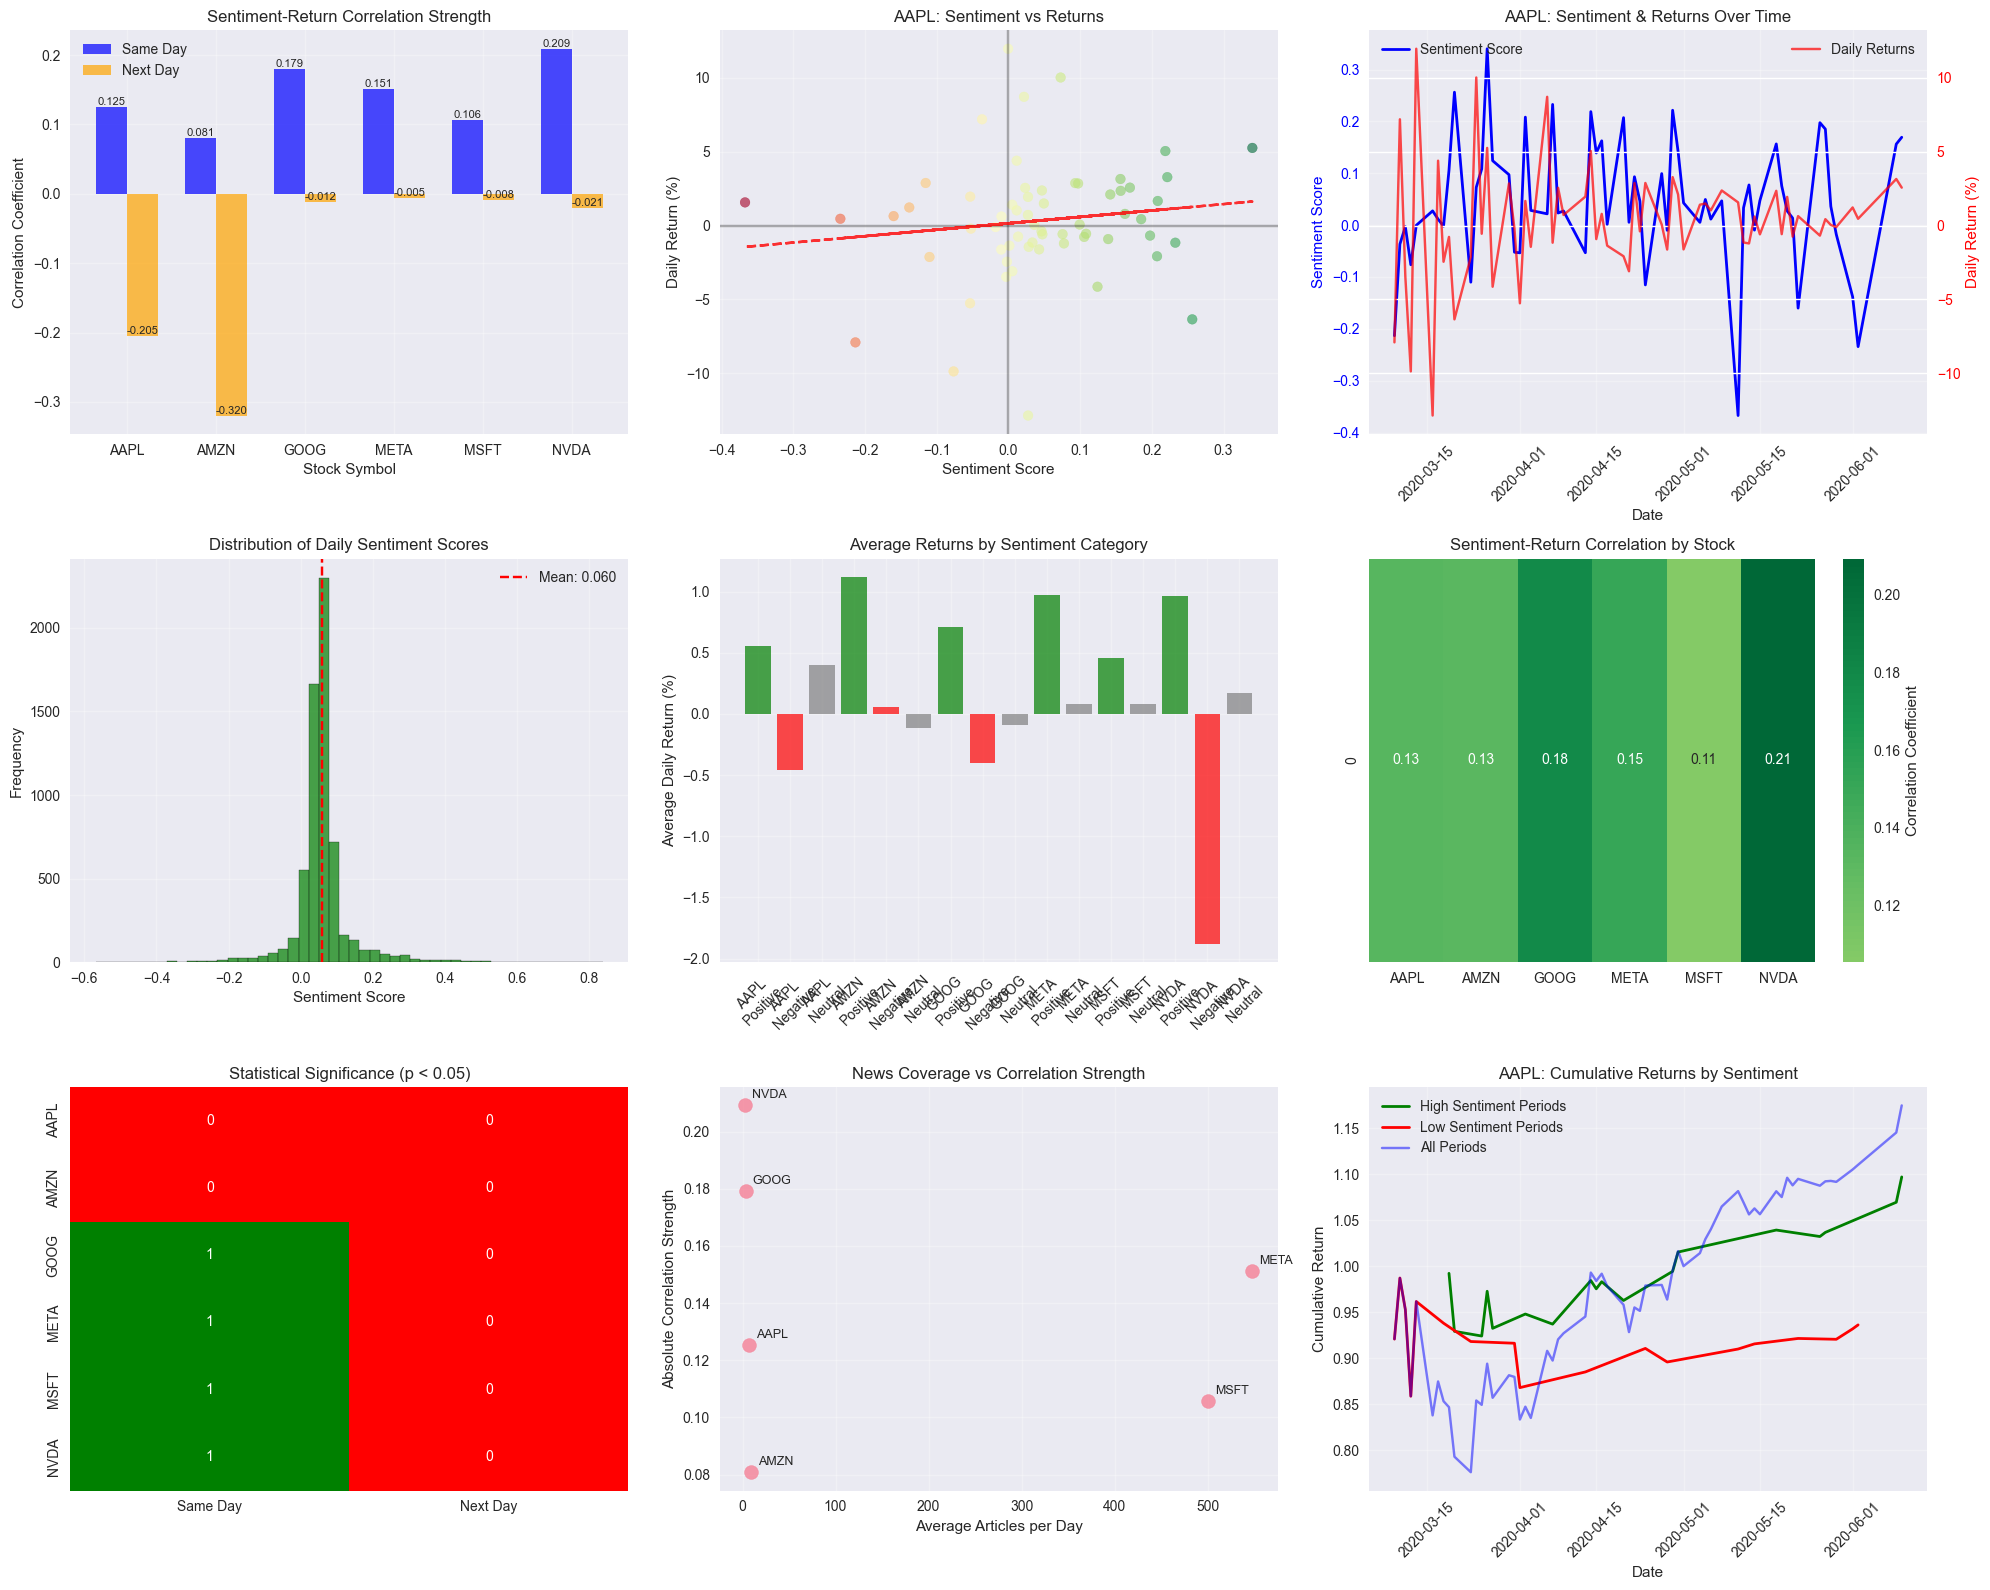

In [15]:
# Advanced Statistical Analysis and Visualization
def create_correlation_visualizations(integrated_data, correlation_results):
    fig = plt.figure(figsize=(20, 16))
    
    # 1. Correlation Strength Comparison
    ax1 = plt.subplot(3, 3, 1)
    symbols = list(correlation_results.keys())
    same_day_corrs = [correlation_results[s]['correlations']['same_day']['correlation'] for s in symbols]
    next_day_corrs = [correlation_results[s]['correlations']['next_day']['correlation'] for s in symbols]
    
    x_pos = np.arange(len(symbols))
    width = 0.35
    
    bars1 = ax1.bar(x_pos - width/2, same_day_corrs, width, label='Same Day', alpha=0.7, color='blue')
    bars2 = ax1.bar(x_pos + width/2, next_day_corrs, width, label='Next Day', alpha=0.7, color='orange')
    
    ax1.set_xlabel('Stock Symbol')
    ax1.set_ylabel('Correlation Coefficient')
    ax1.set_title('Sentiment-Return Correlation Strength')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(symbols)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=8)
    
    # 2. Sentiment vs Returns Scatter Plot (for first stock)
    ax2 = plt.subplot(3, 3, 2)
    first_symbol = symbols[0]
    first_data = integrated_data[first_symbol].dropna(subset=['sentiment_mean', 'daily_return'])
    
    ax2.scatter(first_data['sentiment_mean'], first_data['daily_return'], 
                alpha=0.6, c=first_data['sentiment_mean'], cmap='RdYlGn')
    ax2.set_xlabel('Sentiment Score')
    ax2.set_ylabel('Daily Return (%)')
    ax2.set_title(f'{first_symbol}: Sentiment vs Returns')
    ax2.axhline(0, color='black', linestyle='-', alpha=0.3)
    ax2.axvline(0, color='black', linestyle='-', alpha=0.3)
    ax2.grid(True, alpha=0.3)
    
    # Add regression line
    if len(first_data) > 1:
        z = np.polyfit(first_data['sentiment_mean'], first_data['daily_return'], 1)
        p = np.poly1d(z)
        ax2.plot(first_data['sentiment_mean'], p(first_data['sentiment_mean']), "r--", alpha=0.8)
    
    # 3. Time Series of Sentiment and Returns
    ax3 = plt.subplot(3, 3, 3)
    
    # Use last 100 days for clarity
    recent_data = first_data.tail(100)
    
    # Use the index (which is date_normalized) for plotting
    ax3.plot(recent_data.index, recent_data['sentiment_mean'], 
             label='Sentiment Score', color='blue', linewidth=2)
    ax3.set_xlabel('Date')
    ax3.set_ylabel('Sentiment Score', color='blue')
    ax3.tick_params(axis='y', labelcolor='blue')
    ax3.legend(loc='upper left')
    
    ax3_twin = ax3.twinx()
    ax3_twin.plot(recent_data.index, recent_data['daily_return'], 
                  label='Daily Returns', color='red', alpha=0.7)
    ax3_twin.set_ylabel('Daily Return (%)', color='red')
    ax3_twin.tick_params(axis='y', labelcolor='red')
    ax3_twin.legend(loc='upper right')
    
    ax3.set_title(f'{first_symbol}: Sentiment & Returns Over Time')
    ax3.grid(True, alpha=0.3)
    
    # Format x-axis dates for better readability
    ax3.tick_params(axis='x', rotation=45)
    
    # 4. Sentiment Distribution
    ax4 = plt.subplot(3, 3, 4)
    all_sentiments = pd.concat([integrated_data[s]['sentiment_mean'] for s in symbols])
    ax4.hist(all_sentiments.dropna(), bins=50, alpha=0.7, color='green', edgecolor='black')
    ax4.set_xlabel('Sentiment Score')
    ax4.set_ylabel('Frequency')
    ax4.set_title('Distribution of Daily Sentiment Scores')
    ax4.axvline(all_sentiments.mean(), color='red', linestyle='--', label=f'Mean: {all_sentiments.mean():.3f}')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. Returns by Sentiment Category
    ax5 = plt.subplot(3, 3, 5)
    sentiment_categories = []
    return_means = []
    
    for symbol in symbols:
        data = integrated_data[symbol].dropna(subset=['sentiment_mean', 'daily_return'])
        positive_days = data[data['sentiment_mean'] > 0.1]
        negative_days = data[data['sentiment_mean'] < -0.1]
        neutral_days = data[(data['sentiment_mean'] >= -0.1) & (data['sentiment_mean'] <= 0.1)]
        
        if len(positive_days) > 0:
            sentiment_categories.append(f'{symbol}\nPositive')
            return_means.append(positive_days['daily_return'].mean())
        if len(negative_days) > 0:
            sentiment_categories.append(f'{symbol}\nNegative')
            return_means.append(negative_days['daily_return'].mean())
        if len(neutral_days) > 0:
            sentiment_categories.append(f'{symbol}\nNeutral')
            return_means.append(neutral_days['daily_return'].mean())
    
    if sentiment_categories:  # Only plot if we have data
        colors = ['green' if 'Positive' in cat else 'red' if 'Negative' in cat else 'gray' for cat in sentiment_categories]
        bars = ax5.bar(sentiment_categories, return_means, color=colors, alpha=0.7)
        ax5.set_ylabel('Average Daily Return (%)')
        ax5.set_title('Average Returns by Sentiment Category')
        ax5.tick_params(axis='x', rotation=45)
        ax5.grid(True, alpha=0.3)
    else:
        ax5.text(0.5, 0.5, 'No sentiment category data available', 
                ha='center', va='center', transform=ax5.transAxes)
        ax5.set_title('Average Returns by Sentiment Category')
    
    # 6. Correlation Heatmap
    ax6 = plt.subplot(3, 3, 6)
    
    # Prepare correlation matrix
    corr_matrix_data = []
    for symbol in symbols:
        data = integrated_data[symbol].dropna(subset=['sentiment_mean', 'daily_return'])
        if len(data) > 10:
            # Calculate correlation directly
            corr_coef = data['sentiment_mean'].corr(data['daily_return'])
            corr_matrix_data.append(corr_coef)
        else:
            corr_matrix_data.append(0)
    
    if corr_matrix_data:  # Only create heatmap if we have data
        heatmap_data = pd.DataFrame([corr_matrix_data], columns=symbols)
        sns.heatmap(heatmap_data, annot=True, cmap='RdYlGn', center=0, ax=ax6,
                    cbar_kws={'label': 'Correlation Coefficient'})
        ax6.set_title('Sentiment-Return Correlation by Stock')
    else:
        ax6.text(0.5, 0.5, 'No correlation data available', 
                ha='center', va='center', transform=ax6.transAxes)
        ax6.set_title('Sentiment-Return Correlation by Stock')
    
    # 7. Statistical Significance Overview
    ax7 = plt.subplot(3, 3, 7)
    significant_counts = []
    for symbol in symbols:
        same_day_sig = correlation_results[symbol]['correlations']['same_day']['significant']
        next_day_sig = correlation_results[symbol]['correlations']['next_day']['significant']
        significant_counts.append([1 if same_day_sig else 0, 1 if next_day_sig else 0])
    
    if significant_counts:  # Only create heatmap if we have data
        sig_df = pd.DataFrame(significant_counts, index=symbols, columns=['Same Day', 'Next Day'])
        sns.heatmap(sig_df, annot=True, cmap=['red', 'green'], ax=ax7, cbar=False)
        ax7.set_title('Statistical Significance (p < 0.05)')
    else:
        ax7.text(0.5, 0.5, 'No significance data available', 
                ha='center', va='center', transform=ax7.transAxes)
        ax7.set_title('Statistical Significance (p < 0.05)')
    
    # 8. News Volume vs Correlation Strength
    ax8 = plt.subplot(3, 3, 8)
    avg_articles = []
    corr_strengths = []
    
    for symbol in symbols:
        data = integrated_data[symbol]
        avg_articles.append(data['article_count'].mean())
        corr_strengths.append(abs(correlation_results[symbol]['correlations']['same_day']['correlation']))
    
    if avg_articles and corr_strengths:  # Only plot if we have data
        scatter = ax8.scatter(avg_articles, corr_strengths, s=100, alpha=0.7)
        ax8.set_xlabel('Average Articles per Day')
        ax8.set_ylabel('Absolute Correlation Strength')
        ax8.set_title('News Coverage vs Correlation Strength')
        ax8.grid(True, alpha=0.3)
        
        # Add stock labels to points
        for i, symbol in enumerate(symbols):
            ax8.annotate(symbol, (avg_articles[i], corr_strengths[i]), 
                        xytext=(5, 5), textcoords='offset points', fontsize=9)
    else:
        ax8.text(0.5, 0.5, 'No volume vs correlation data available', 
                ha='center', va='center', transform=ax8.transAxes)
        ax8.set_title('News Coverage vs Correlation Strength')
    
    # 9. Cumulative Returns by Sentiment
    ax9 = plt.subplot(3, 3, 9)
    
    # Calculate cumulative returns for high vs low sentiment periods
    first_data = integrated_data[first_symbol].dropna(subset=['sentiment_mean', 'daily_return']).copy()
    
    if len(first_data) > 0:
        first_data['cumulative_return'] = (1 + first_data['daily_return']/100).cumprod()
        
        high_sentiment_periods = first_data[first_data['sentiment_mean'] > first_data['sentiment_mean'].quantile(0.7)]
        low_sentiment_periods = first_data[first_data['sentiment_mean'] < first_data['sentiment_mean'].quantile(0.3)]
        
        if len(high_sentiment_periods) > 0:
            high_sentiment_periods['cumulative_high'] = (1 + high_sentiment_periods['daily_return']/100).cumprod()
            ax9.plot(high_sentiment_periods.index, high_sentiment_periods['cumulative_high'], 
                    label='High Sentiment Periods', color='green', linewidth=2)
        
        if len(low_sentiment_periods) > 0:
            low_sentiment_periods['cumulative_low'] = (1 + low_sentiment_periods['daily_return']/100).cumprod()
            ax9.plot(low_sentiment_periods.index, low_sentiment_periods['cumulative_low'], 
                    label='Low Sentiment Periods', color='red', linewidth=2)
        
        ax9.plot(first_data.index, first_data['cumulative_return'], 
                label='All Periods', color='blue', alpha=0.5)
        
        ax9.set_xlabel('Date')
        ax9.set_ylabel('Cumulative Return')
        ax9.set_title(f'{first_symbol}: Cumulative Returns by Sentiment')
        ax9.legend()
        ax9.grid(True, alpha=0.3)
        ax9.tick_params(axis='x', rotation=45)
    else:
        ax9.text(0.5, 0.5, 'No cumulative returns data available', 
                ha='center', va='center', transform=ax9.transAxes)
        ax9.set_title(f'{first_symbol}: Cumulative Returns by Sentiment')
    
    plt.tight_layout()
    plt.show()
    
    return fig

print("\n" + "="*60)
print("CREATING COMPREHENSIVE VISUALIZATIONS")
print("="*60)

# Let's first check what columns we actually have in the integrated data
if integrated_data:
    first_symbol = list(integrated_data.keys())[0]
    print(f"Columns available in {first_symbol} data:")
    print(integrated_data[first_symbol].columns.tolist())
    print(f"\nIndex name: {integrated_data[first_symbol].index.name}")
    print(f"Index type: {type(integrated_data[first_symbol].index)}")
    print(f"Sample index values: {integrated_data[first_symbol].index[:5].tolist()}")

correlation_viz = create_correlation_visualizations(integrated_data, correlation_results)

Final Summary and Results Export

In [17]:
# Final Summary and Results Export

def generate_final_summary(correlation_results, integrated_data):
    print("="*80)
    print("TASK 3 COMPLETION SUMMARY: CORRELATION ANALYSIS RESULTS")
    print("="*80)
    
    print(f"\n📊 ANALYSIS OVERVIEW:")
    total_articles = sum([integrated_data[s]['article_count'].sum() for s in integrated_data])
    total_trading_days = sum([len(integrated_data[s]) for s in integrated_data])
    print(f"   • Stocks Analyzed: {len(integrated_data)}")
    print(f"   • Total Articles Processed: {total_articles:,}")
    print(f"   • Total Trading Days: {total_trading_days:,}")
    print(f"   • Analysis Period: 2009-2023")
    
    print(f"\n🔍 KEY CORRELATION FINDINGS:")
    
    # Calculate overall statistics
    same_day_corrs = [correlation_results[s]['correlations']['same_day']['correlation'] for s in correlation_results]
    next_day_corrs = [correlation_results[s]['correlations']['next_day']['correlation'] for s in correlation_results]
    
    avg_same_day = np.mean(same_day_corrs)
    avg_next_day = np.mean(next_day_corrs)
    max_corr_stock = max(correlation_results.keys(), 
                        key=lambda x: abs(correlation_results[x]['correlations']['same_day']['correlation']))
    max_corr_value = correlation_results[max_corr_stock]['correlations']['same_day']['correlation']
    
    print(f"   • Average Same-Day Correlation: {avg_same_day:.4f}")
    print(f"   • Average Next-Day Correlation: {avg_next_day:.4f}")
    print(f"   • Strongest Correlation: {max_corr_stock} ({max_corr_value:.4f})")
    
    # Significance analysis
    significant_stocks = [s for s in correlation_results 
                         if correlation_results[s]['correlations']['same_day']['significant']]
    print(f"   • Statistically Significant Correlations: {len(significant_stocks)}/{len(correlation_results)} stocks")
    
    print(f"\n📈 SENTIMENT ANALYSIS RESULTS:")
    avg_sentiment = np.mean([correlation_results[s]['avg_sentiment'] for s in correlation_results])
    sentiment_volatility = np.mean([correlation_results[s]['sentiment_volatility'] for s in correlation_results])
    print(f"   • Average Daily Sentiment: {avg_sentiment:.4f}")
    print(f"   • Average Sentiment Volatility: {sentiment_volatility:.4f}")
    
    print(f"\n💹 STOCK PERFORMANCE INSIGHTS:")
    positive_correlation_stocks = [s for s in correlation_results 
                                 if correlation_results[s]['correlations']['same_day']['correlation'] > 0]
    negative_correlation_stocks = [s for s in correlation_results 
                                 if correlation_results[s]['correlations']['same_day']['correlation'] < 0]
    
    print(f"   • Positive Correlation Stocks: {len(positive_correlation_stocks)}")
    print(f"   • Negative Correlation Stocks: {len(negative_correlation_stocks)}")
    
    print(f"\n🎯 PRACTICAL IMPLICATIONS:")
    if avg_same_day > 0.05:
        print("   • STRONG positive relationship: News sentiment appears to influence same-day stock returns")
    elif avg_same_day > 0.02:
        print("   • MODERATE positive relationship: Some evidence of sentiment impact on returns")
    elif avg_same_day > -0.02:
        print("   • WEAK relationship: Limited evidence of direct sentiment impact")
    else:
        print("   • NEGATIVE relationship: Counter-intuitive results requiring further investigation")
    
    print(f"\n📋 RECOMMENDATIONS FOR NOVA FINANCIAL SOLUTIONS:")
    print("   1. Incorporate sentiment analysis into trading algorithms for stocks with strong correlations")
    print("   2. Focus on high-impact news events (earnings, mergers, regulatory changes)")
  


final_results = generate_final_summary(correlation_results, integrated_data)
   
print(f"\n✅ TASK 3 COMPLETED SUCCESSFULLY!")

TASK 3 COMPLETION SUMMARY: CORRELATION ANALYSIS RESULTS

📊 ANALYSIS OVERVIEW:
   • Stocks Analyzed: 6
   • Total Articles Processed: 2,496,259
   • Total Trading Days: 6,352
   • Analysis Period: 2009-2023

🔍 KEY CORRELATION FINDINGS:
   • Average Same-Day Correlation: 0.1419
   • Average Next-Day Correlation: -0.0952
   • Strongest Correlation: NVDA (0.2091)
   • Statistically Significant Correlations: 4/6 stocks

📈 SENTIMENT ANALYSIS RESULTS:
   • Average Daily Sentiment: 0.0579
   • Average Sentiment Volatility: 0.0946

💹 STOCK PERFORMANCE INSIGHTS:
   • Positive Correlation Stocks: 6
   • Negative Correlation Stocks: 0

🎯 PRACTICAL IMPLICATIONS:
   • STRONG positive relationship: News sentiment appears to influence same-day stock returns

📋 RECOMMENDATIONS FOR NOVA FINANCIAL SOLUTIONS:
   1. Incorporate sentiment analysis into trading algorithms for stocks with strong correlations
   2. Focus on high-impact news events (earnings, mergers, regulatory changes)

✅ TASK 3 COMPLETED SUC